In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavchandane/scut-fbp5500-v2-facial-beauty-scores")

print("Path to dataset files:", path)

/home/reynaldy/anaconda3/envs/unsloth_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.12G/1.12G [01:48<00:00, 11.1MB/s]

Extracting files...


Path to dataset files: /home/reynaldy/.cache/kagglehub/datasets/pranavchandane/scut-fbp5500-v2-facial-beauty-scores/versions/2


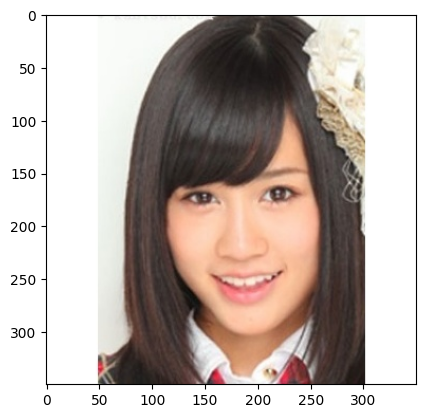

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# Define your image path
image_path = "/home/reynaldy/.cache/kagglehub/datasets/pranavchandane/scut-fbp5500-v2-facial-beauty-scores/versions/2/Images/Images/AF1022.jpg"

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis("on")  # Hide axes for better visualization
plt.show()


According to the dataset on kaggle, all images are 350 x 350 px and already in numpy, so we will just use that for now

In [24]:
import numpy as np
data_path = '/home/reynaldy/.cache/kagglehub/datasets/pranavchandane/scut-fbp5500-v2-facial-beauty-scores/versions/2/scut_fbp5500-cmprsd.npz'

data = np.load(data_path)
data['X'].shape, data['y'].shape


((5500, 350, 350, 3), (5500,))

In [2]:
print(type(data['X']), type(data['y']))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [25]:
# Reduce image size into 256 x 256 
features_numpy = data['X'].astype(np.float32) 

import cv2
features_numpy = np.array([cv2.resize(img, (128, 128)) for img in features_numpy])
print(features_numpy.shape)

(5500, 128, 128, 3)


In [26]:
import torch

features = torch.tensor(features_numpy, dtype=torch.float32)
print(features.shape)
label_numpy = data['y'].astype(np.float32)
labels = torch.tensor(label_numpy, dtype=torch.float32)

torch.Size([5500, 128, 128, 3])


In [27]:
print(features.max(), features.min()) # make sure the tensor already make sense

tensor(255.) tensor(0.)


In [28]:
print(labels.min(), labels.max())

tensor(1.0167) tensor(4.7500)


In [29]:
# Normalize thelabel score to 0-1
tensor_min = labels.min()
tensor_max = labels.max()

labels = (labels - tensor_min) / (tensor_max - tensor_min)
print(labels.min(), labels.max())

tensor(0.) tensor(1.)


In [30]:
# Change features shape into (batch, channel, height, width)

features = features.permute(0, 3, 1, 2)
features.shape

torch.Size([5500, 3, 128, 128])

In [31]:
# Split the data into training and validation set

from torch.utils.data import DataLoader, TensorDataset, random_split

train_size = int(0.8 * len(features))
test_size = len(features) - train_size

train_dataset, test_dataset = random_split(TensorDataset(features, labels), [train_size, test_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 4400
Test samples: 1100


In [32]:
# Data loader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
# Checking the data loader
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print("Data:", data)
    print("Target:", target)
    break

Batch 1:
Data: tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 2

In [34]:
# Model building (3 input channel and 1 output channel as we are doing regression) 
import torch
import torch.nn as nn

class BeautyScore(nn.Module):
    def __init__(self, first_neuron):
        super(BeautyScore, self).__init__()

        self.first_out_channels = first_neuron
        
        self.features = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(in_channels=3, out_channels=self.first_out_channels, kernel_size=3, padding=1),  # dimension [batch_size, out_channel, 128, `128`] -> padding = 1
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels),
            nn.MaxPool2d(2), # dimension [batch_size, out_channel, 64, 64]
            
            # Second Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels, out_channels=self.first_out_channels*2, kernel_size=3, padding=1), # dimension [batch_size, out_channel, 32, 32]
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*2),
            nn.MaxPool2d(2), # dimension [batch_size, out_channel*2, 32, 32]
            
            # Third Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels*2, out_channels=self.first_out_channels*4, kernel_size=3, padding=1), # dimension [batch_size, out_channel, 16, 16]
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*4),
            nn.MaxPool2d(2), # dimension [batch_size, out_channel*4, 16, 16]
            
        )
        
        # Calculate size of flattened features after the convolutional layers
        self.flatten_size = self.first_out_channels * 4 * (128 // (2**3)) * (128 // (2**3)) # out_channel * (128 // 2^amount_of_max_pool) * (128 // 2^amount_of_max_pool)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flatten_size, 256), # dimension [batch_size, 256]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), # dimension [batch_size, 128]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1), # dimension [batch_size, 1]
            nn.Sigmoid() # To get value from 0 to 1
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


In [38]:
# Training Loop Function

def train(model, train_loader, criterion, optimizer, scheduler = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if (batch_idx + 1) % 20 == 0:
            print(f"Batch {batch_idx + 1}/{len(train_loader)} Loss: {loss.item()}")
        
    

    epoch_loss = running_loss / len(train_loader)
    if scheduler:
        scheduler.step(epoch_loss)
    print(f"Training Loss: {epoch_loss:.4f}")
    return epoch_loss

def validate(model, val_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            running_loss += loss.item()
            
    epoch_loss = running_loss / len(val_loader)
    print(f"Validation Loss: {epoch_loss:.4f}")
    return epoch_loss


In [39]:
# Model Initialization
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = BeautyScore(first_neuron=256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = nn.MSELoss()

In [41]:
# Training Loop

num_epochs = 20
best_val_loss = 0.0161
model.load_state_dict(torch.load('best_model.pth'))
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loss = train(model, train_loader, criterion, optimizer, scheduler)
    val_loss = validate(model, val_loader, criterion)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saving the best model")
    
    print()

torch.save(model.state_dict(), 'model.pth')

/tmp/ipykernel_20550/3309392625.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1
-------------------------------
Batch 20/138 Loss: 0.009027991443872452
Batch 40/138 Loss: 0.01668451353907585
Batch 60/138 Loss: 0.01481441967189312
Batch 80/138 Loss: 0.01588061824440956
Batch 100/138 Loss: 0.012532966211438179
Batch 120/138 Loss: 0.015258612111210823
Training Loss: 0.0129
Validation Loss: 0.0161

Epoch 2
-------------------------------
Batch 20/138 Loss: 0.009501738473773003
Batch 40/138 Loss: 0.0094308378174901
Batch 60/138 Loss: 0.009190799668431282
Batch 80/138 Loss: 0.0197311881929636
Batch 100/138 Loss: 0.008830913342535496
Batch 120/138 Loss: 0.010924957692623138
Training Loss: 0.0129
Validation Loss: 0.0159
Saving the best model

Epoch 3
-------------------------------
Batch 20/138 Loss: 0.011084266006946564
Batch 40/138 Loss: 0.009692691266536713
Batch 60/138 Loss: 0.007824134081602097
Batch 80/138 Loss: 0.013438081368803978
Batch 100/138 Loss: 0.008513936772942543
Batch 120/138 Loss: 0.014486919157207012
Training Loss: 0.0124
Validation Loss: 0.0159